In [1]:
pwd

'/Users/zhangyanyi/Desktop/scrambler/examples/dna'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0,'/Users/zhangyanyi/Desktop/scrambler/')
sys.path.insert(0,'/Users/zhangyanyi/Desktop/scrambler/scrambler')
sys.path.insert(0,'/Users/zhangyanyi/Desktop/scrambler/examples/dna')
print(sys.path)

['/Users/zhangyanyi/Desktop/scrambler/examples/dna', '/Users/zhangyanyi/Desktop/scrambler/scrambler', '/Users/zhangyanyi/Desktop/scrambler/', '/opt/anaconda3/envs/scrambler/lib/python36.zip', '/opt/anaconda3/envs/scrambler/lib/python3.6', '/opt/anaconda3/envs/scrambler/lib/python3.6/lib-dynload', '', '/opt/anaconda3/envs/scrambler/lib/python3.6/site-packages', '/opt/anaconda3/envs/scrambler/lib/python3.6/site-packages/IPython/extensions', '/Users/zhangyanyi/.ipython']


In [4]:
import keras
from keras.models import Sequential, Model, load_model

import os
import pickle
import numpy as np
import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from scrambler.models import *
from scrambler.utils import OneHotEncoder, get_sequence_masks
from scrambler.visualizations import plot_dna_logo, plot_dna_importance_scores

from apa_utils import load_apa_data, load_apa_predictor, animate_apa_examples

from synthetic import *


Using TensorFlow backend.
/opt/anaconda3/envs/scrambler/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/scrambler/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/scrambler/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/scrambler/lib/p

In [5]:
#Load APA data and predictor

encoder = OneHotEncoder(seq_length=205, channel_map={'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3})

data_path = 'apa_doubledope_cached_set.csv'

x_train, y_train, x_test, y_test = load_apa_data(data_path, encoder)

# x_train, y_train, x_test, y_test = data_generation()

predictor_path = 'saved_models/aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'

predictor = load_apa_predictor(predictor_path)


len(data_df) = 34748 (loaded)
x_train.shape = (32992, 1, 205, 4)
y_train.shape = (32992, 1)
x_test.shape = (1728, 1, 205, 4)
y_test.shape = (1728, 1)
x_train:  [[[[0. 1. 0. 0.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   ...
   [0. 0. 0. 1.]
   [1. 0. 0. 0.]
   [0. 1. 0. 0.]]]


 [[[0. 1. 0. 0.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   ...
   [0. 0. 0. 1.]
   [1. 0. 0. 0.]
   [0. 1. 0. 0.]]]


 [[[0. 1. 0. 0.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   ...
   [0. 0. 0. 1.]
   [1. 0. 0. 0.]
   [0. 1. 0. 0.]]]


 ...


 [[[0. 1. 0. 0.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   ...
   [0. 0. 0. 1.]
   [1. 0. 0. 0.]
   [0. 1. 0. 0.]]]


 [[[0. 1. 0. 0.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   ...
   [0. 0. 0. 1.]
   [1. 0. 0. 0.]
   [0. 1. 0. 0.]]]


 [[[0. 1. 0. 0.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   ...
   [0. 0. 0. 1.]
   [1. 0. 0. 0.]
   [0. 1. 0. 0.]]]]
y_train:  [[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.18181818]
 [0.89795918]
 [0.90909091]]


In [6]:
#Define sequence template and background

#******How to use this sequence_template
sequence_template = 'CTTCCGATCT$$$$$$$$$$$$$$$$$$$$CATTACTCGCATCCA$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$CAGCCAATTAAGCC$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$CTAC'

pseudo_count = 1.0 # Why pseudo_count?

onehot_template = encoder(sequence_template)[None, ...]
print("onehot_template.shape: ", onehot_template.shape)
#print("onehot_template: ", onehot_template)

sequence_mask = get_sequence_masks([sequence_template])[0]
print("sequence_mask.shape: ", sequence_mask.shape)
#print("sequence_mask: ", sequence_mask)

x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)
print("x_mean.shape: ", x_mean.shape)
#print("x_mean: ", x_mean)


onehot_template.shape:  (1, 205, 4)
onehot_template:  [[[0. 1. 0. 0.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]
  [0. 0. 0. 1.]
  [0. 1. 0. 0.]
  [0. 0. 0. 1.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 0. 1.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 0. 1.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  

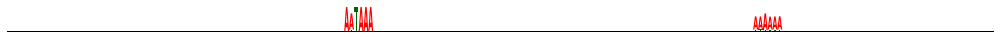

In [6]:
#Visualize background sequence distribution
#Need to further look into.
plot_dna_logo(np.copy(x_mean), sequence_template=sequence_template, figsize=(14, 0.65), logo_height=1.0, plot_start=0, plot_end=205)


In [15]:
#Calculate mean training set kl-divergence against background

x_train_clipped = np.clip(np.copy(x_train[:, 0, :, :]), 1e-8, 1. - 1e-8)
print("x_train_clipped.shape: ", x_train_clipped.shape)
#print("x_train_clipped: ", x_train_clipped)

kl_divs = np.sum(x_train_clipped * np.log(x_train_clipped / np.tile(np.expand_dims(x_mean, axis=0), (x_train_clipped.shape[0], 1, 1))), axis=-1) / np.log(2.0)
print("kl_divs.shape: ", kl_divs.shape)
print("kl_divs: ", kl_divs)

x_mean_kl_divs = np.sum(kl_divs * sequence_mask, axis=-1) / np.sum(sequence_mask)
print("x_mean_kl_divs.shape: ", x_mean_kl_divs.shape)
print("x_mean_kl_divs: ", x_mean_kl_divs)
      
x_mean_kl_div = np.mean(x_mean_kl_divs)
print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))


x_train_clipped.shape:  (32992, 205, 4)
kl_divs.shape:  (32992, 205)
kl_divs:  [[0.00013081 0.00013081 0.00013081 ... 0.00013081 0.00013081 0.00013081]
 [0.00013081 0.00013081 0.00013081 ... 0.00013081 0.00013081 0.00013081]
 [0.00013081 0.00013081 0.00013081 ... 0.00013081 0.00013081 0.00013081]
 ...
 [0.00013081 0.00013081 0.00013081 ... 0.00013081 0.00013081 0.00013081]
 [0.00013081 0.00013081 0.00013081 ... 0.00013081 0.00013081 0.00013081]
 [0.00013081 0.00013081 0.00013081 ... 0.00013081 0.00013081 0.00013081]]
x_mean_kl_divs.shape:  (32992,)
x_mean_kl_divs:  [1.87737269 1.86373617 1.86789825 ... 1.85214309 1.86612666 1.90223   ]
Mean KL Div against background (bits) = 1.8729476983107292


In [8]:
#Build scrambler

#Scrambler network configuration
network_config = {
    'n_groups' : 5,
    'n_resblocks_per_group' : 4,
    'n_channels' : 32,
    'window_size' : 3,
    'dilation_rates' : [1, 2, 4, 2, 1],
    'drop_rate' : 0.0,
    'norm_mode' : 'instance', # instance, batch, conv
    'mask_smoothing' : True,
    'mask_smoothing_window_size' : 5,
    'mask_smoothing_std' : 1.,
    'mask_drop_scales' : [1, 5],
    'mask_min_drop_rate' : 0.0,
    'mask_max_drop_rate' : 0.5,
    'label_input' : False
}

#Initialize scrambler
scrambler = Scrambler(
    scrambler_mode='inclusion',
    input_size_x=1,
    input_size_y=205,
    n_out_channels=4,
    input_templates=[onehot_template],
    input_backgrounds=[x_mean],
    batch_size=32,
    n_samples=32,
    sample_mode='st',
    zeropad_input=False,
    mask_dropout=False,
    network_config=network_config
)


In [9]:
#Train scrambler
n_epochs = 10

train_history = scrambler.train(
    predictor,
    x_train,
    y_train,
    x_test,
    y_test,
    n_epochs,
    monitor_test_indices=np.arange(32).tolist(),
    monitor_batch_freq_dict={0 : 1, 100 : 5, 1031 : 10},
    nll_mode='reconstruction', # reconstruction, maximization, minimization
    predictor_task='classification_sym', # classification, classification_sym, regression
    entropy_mode='target', # target, maximization
    entropy_bits=0.25,
    entropy_weight=1.
)


Train on 32992 samples, validate on 1728 samples
Epoch 1/10
32992/32992 [==============================] - 3464s 105ms/step - loss: 0.4667 - nll_loss: 0.4256 - entropy_loss: 0.0411 - val_loss: 0.3855 - val_nll_loss: 0.3531 - val_entropy_loss: 0.0324
Epoch 2/10
32992/32992 [==============================] - 3107s 94ms/step - loss: 0.3700 - nll_loss: 0.3433 - entropy_loss: 0.0267 - val_loss: 0.3366 - val_nll_loss: 0.3132 - val_entropy_loss: 0.0233
Epoch 3/10
32992/32992 [==============================] - 3109s 94ms/step - loss: 0.3311 - nll_loss: 0.3092 - entropy_loss: 0.0220 - val_loss: 0.3189 - val_nll_loss: 0.3009 - val_entropy_loss: 0.0179
Epoch 4/10
32992/32992 [==============================] - 3109s 94ms/step - loss: 0.3081 - nll_loss: 0.2887 - entropy_loss: 0.0194 - val_loss: 0.3053 - val_nll_loss: 0.2843 - val_entropy_loss: 0.0210
Epoch 5/10
32992/32992 [==============================] - 3111s 94ms/step - loss: 0.2911 - nll_loss: 0.2740 - entropy_loss: 0.0171 - val_loss: 0.3071 

In [10]:
#Save scrambler checkpoint
save_dir = 'saved_models'

# model_name = 'apa_inclusion_scrambler_smooth_target_bits_025_epochs_10_deeper'
model_name = 'synthetic_inclusion_scrambler_smooth_target_bits_025_epochs_10_deeper'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')

scrambler.save_model(model_path)

pickle.dump({'train_history' : train_history}, open(save_dir + '/' + model_name + '_train_history.pickle', 'wb'))


Saved scrambler model at saved_models/synthetic_inclusion_scrambler_smooth_target_bits_025_epochs_10_deeper.h5 


In [11]:
#Load models
save_dir = 'saved_models'

model_name = 'apa_inclusion_scrambler_smooth_target_bits_025_epochs_10_deeper'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')

scrambler.load_model(model_path)


Loaded scrambler model from saved_models/apa_inclusion_scrambler_smooth_target_bits_025_epochs_10_deeper.h5 


n_epochs_actual:  10


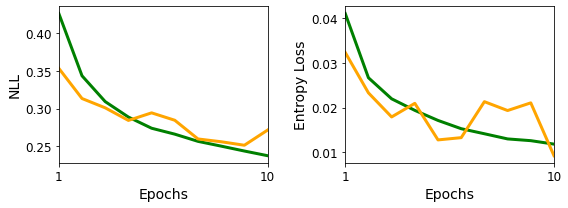

In [12]:
#Plot training statistics

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 4, 3))

n_epochs_actual = len(train_history['nll_loss'])
print("n_epochs_actual: ", n_epochs_actual)

ax1.plot(np.arange(1, n_epochs_actual + 1), train_history['nll_loss'], linewidth=3, color='green')
ax1.plot(np.arange(1, n_epochs_actual + 1), train_history['val_nll_loss'], linewidth=3, color='orange')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

ax2.plot(np.arange(1, n_epochs_actual + 1), train_history['entropy_loss'], linewidth=3, color='green')
ax2.plot(np.arange(1, n_epochs_actual + 1), train_history['val_entropy_loss'], linewidth=3, color='orange')

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Entropy Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


In [13]:
#Interpret the test set using the trained scrambler

pwm_test, sample_test, importance_scores_test = scrambler.interpret(x_test)


1728/1728 [==============================] - 22s 13ms/step


Test sequence 0:
 - Prediction (original) = 0.09
 - Predictions (scrambled) = [0.05, 0.03, 0.06, 0.22, 0.04, 0.02, 0.04, 0.06, 0.06, 0.01, 0.06, 0.02, 0.02, 0.12, 0.0, 0.02, 0.03, 0.01, 0.07, 0.03, 0.02, 0.01, 0.28, 0.02, 0.04, 0.24, 0.09, 0.02, 0.02, 0.15, 0.05, 0.22]


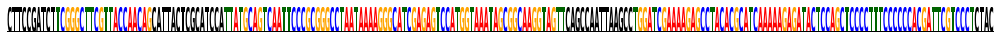

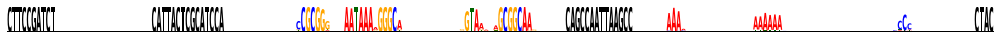

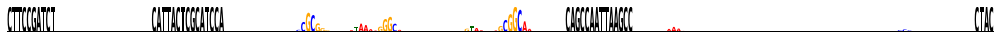

Test sequence 1:
 - Prediction (original) = 0.18
 - Predictions (scrambled) = [0.83, 0.25, 0.31, 0.05, 0.16, 0.01, 0.13, 0.05, 0.74, 0.03, 0.13, 0.09, 0.21, 0.47, 0.04, 0.26, 0.1, 0.08, 0.12, 0.03, 0.36, 0.39, 0.1, 0.23, 0.07, 0.59, 0.04, 0.06, 0.24, 0.43, 0.04, 0.05]


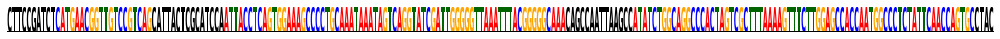

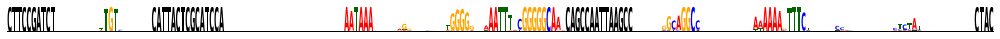

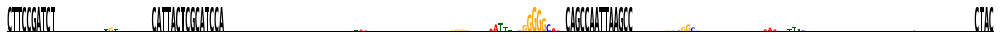

Test sequence 2:
 - Prediction (original) = 0.78
 - Predictions (scrambled) = [0.62, 0.72, 0.92, 0.48, 0.68, 0.68, 0.53, 0.53, 0.78, 0.56, 0.51, 0.43, 0.62, 0.46, 0.85, 0.72, 0.51, 0.66, 0.83, 0.96, 0.58, 0.52, 0.29, 0.56, 0.65, 0.67, 0.6, 0.53, 0.81, 0.83, 0.61, 0.56]


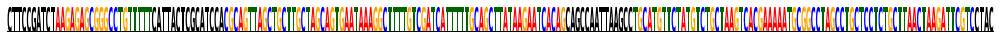

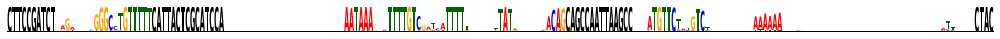

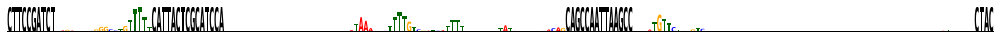

Test sequence 3:
 - Prediction (original) = 0.15
 - Predictions (scrambled) = [0.12, 0.05, 0.15, 0.07, 0.42, 0.23, 0.04, 0.41, 0.1, 0.15, 0.34, 0.16, 0.02, 0.35, 0.21, 0.03, 0.39, 0.21, 0.18, 0.06, 0.3, 0.12, 0.06, 0.29, 0.05, 0.05, 0.39, 0.04, 0.21, 0.28, 0.15, 0.1]


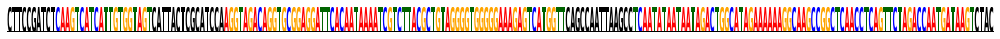

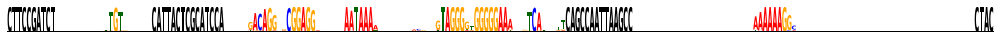

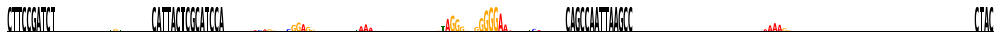

Test sequence 4:
 - Prediction (original) = 0.27
 - Predictions (scrambled) = [0.4, 0.14, 0.48, 0.64, 0.66, 0.14, 0.69, 0.19, 0.43, 0.15, 0.87, 0.15, 0.21, 0.24, 0.52, 0.06, 0.2, 0.08, 0.62, 0.25, 0.67, 0.62, 0.44, 0.08, 0.47, 0.6, 0.14, 0.6, 0.1, 0.18, 0.71, 0.34]


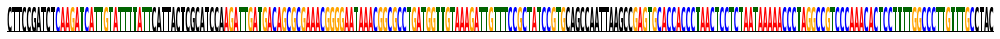

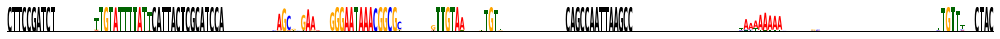

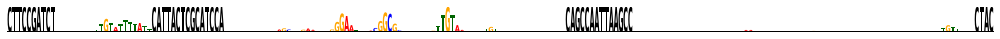

Test sequence 5:
 - Prediction (original) = 0.67
 - Predictions (scrambled) = [0.67, 0.88, 0.59, 0.26, 0.91, 0.73, 0.36, 0.48, 0.75, 0.71, 0.78, 0.56, 0.77, 0.17, 0.96, 0.49, 0.45, 0.47, 0.28, 0.42, 0.58, 0.36, 0.97, 0.61, 0.33, 0.74, 0.85, 0.74, 0.43, 0.1, 0.4, 0.66]


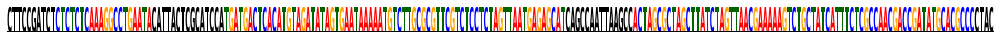

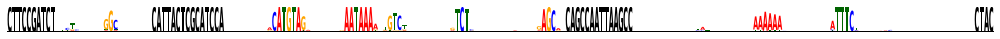

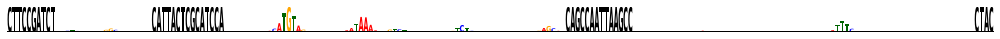

Test sequence 6:
 - Prediction (original) = 0.93
 - Predictions (scrambled) = [0.73, 0.9, 0.86, 0.84, 0.91, 0.92, 0.52, 0.92, 0.75, 0.83, 0.98, 0.72, 0.68, 0.97, 0.88, 0.94, 0.92, 0.79, 0.92, 0.96, 0.83, 0.71, 0.86, 0.69, 0.91, 0.61, 0.5, 0.48, 0.64, 0.91, 0.79, 0.95]


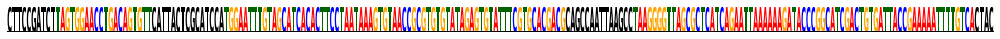

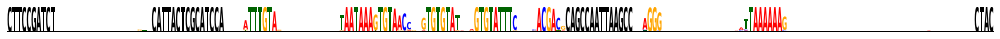

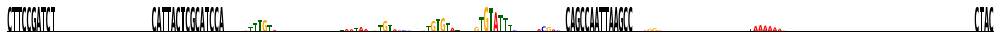

Test sequence 7:
 - Prediction (original) = 0.84
 - Predictions (scrambled) = [0.45, 0.1, 0.63, 0.27, 0.4, 0.5, 0.31, 0.75, 0.09, 0.17, 0.43, 0.45, 0.69, 0.26, 0.63, 0.52, 0.3, 0.36, 0.53, 0.42, 0.67, 0.08, 0.52, 0.29, 0.78, 0.23, 0.75, 0.11, 0.39, 0.81, 0.18, 0.65]


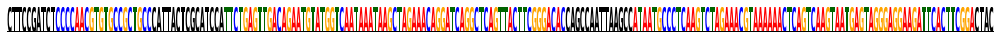

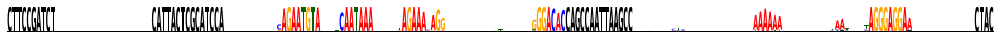

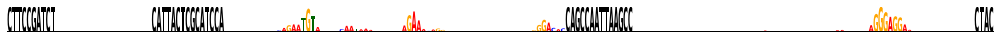

Test sequence 8:
 - Prediction (original) = 0.6
 - Predictions (scrambled) = [0.17, 0.55, 0.32, 0.72, 0.2, 0.49, 0.55, 0.84, 0.44, 0.73, 0.55, 0.76, 0.75, 0.46, 0.31, 0.33, 0.7, 0.3, 0.34, 0.23, 0.58, 0.77, 0.8, 0.84, 0.42, 0.2, 0.65, 0.57, 0.58, 0.57, 0.48, 0.87]


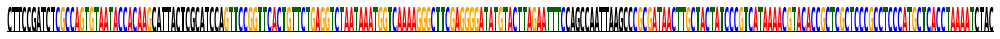

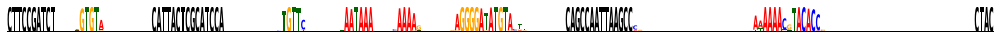

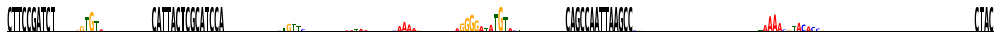

Test sequence 9:
 - Prediction (original) = 0.65
 - Predictions (scrambled) = [0.3, 0.69, 0.94, 0.58, 0.75, 0.11, 0.9, 0.72, 0.5, 0.63, 0.2, 0.65, 0.56, 0.58, 0.51, 0.39, 0.65, 0.55, 0.33, 0.14, 0.57, 0.49, 0.48, 0.28, 0.39, 0.77, 0.32, 0.49, 0.39, 0.22, 0.67, 0.94]


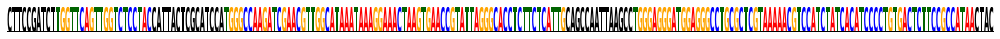

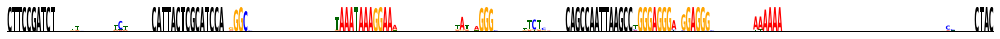

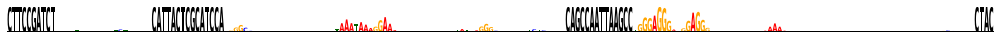

In [14]:
#Visualize a few reconstructed sequence patterns

plot_examples = np.arange(10).tolist()
save_examples = []

importance_scores_test *= sequence_mask[None, None, :, None]

for test_ix in plot_examples :
    
    print("Test sequence " + str(test_ix) + ":")
    
    y_test_hat_ref = predictor.predict(x=[x_test[test_ix:test_ix+1, ...]], batch_size=1)[0, 0]
    y_test_hat = predictor.predict(x=[sample_test[test_ix, ...]], batch_size=32)[:32, 0].tolist()
    
    print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])
    print(" - Predictions (scrambled) = " + str([float(str(round(y_test_hat[i], 2))[:4]) for i in range(len(y_test_hat))]))
    
    save_figs = False
    if save_examples is not None and test_ix in save_examples :
        save_figs = True
    
    plot_dna_logo(x_test[test_ix, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_orig_sequence")
    plot_dna_logo(pwm_test[test_ix, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scrambld_pwm")
    plot_dna_importance_scores(importance_scores_test[test_ix, 0, :, :].T, encoder.decode(x_test[test_ix, 0, :, :]), figsize=(14, 0.65), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=205, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scores")
    